In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import scipy
from data_io import read_iq_data
from filters import simple_squelch, decimating_fir_filter
from visualisation import plot_payload, compare_bits_with_reference, subplots_iq, plot_ber_vs_frequency_offset
from receiver import ReceiverBLE, Receiver802154
from interference_utils import (
    multiply_by_complex_exponential,
    pad_interference,
    correlation_wrapper,
    subtract_interference_wrapper,
    compute_ber_vs_frequency,
)

# Read reference for BER comparison

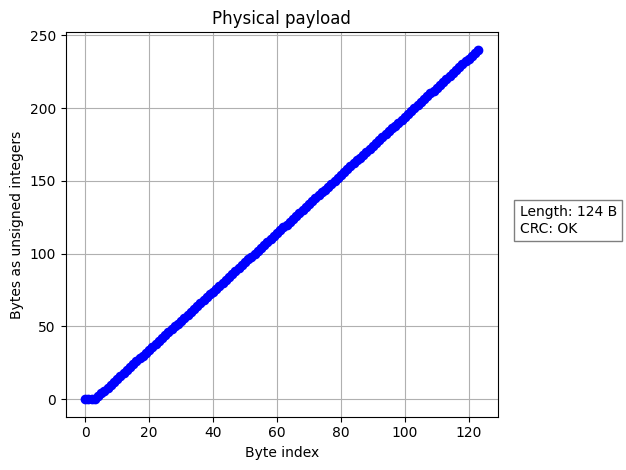

In [2]:
filename: str = "BLE_0dBm.dat"
fs: int | float = 10e6  # Hz
decimation: int = 1

# Open file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")

# Initialise the receiver and process data
receiver = ReceiverBLE(fs=fs, decimation=decimation)
bit_samples = receiver.demodulate(iq_samples)  # From IQ samples to hard decisions
reference_packet: list[dict] = receiver.process_phy_packet(bit_samples)  # From hard decisions to packets
reference_packet: dict = reference_packet[0]
plot_payload(reference_packet)
plt.show()

# Read interferenced packet and compare (BER)

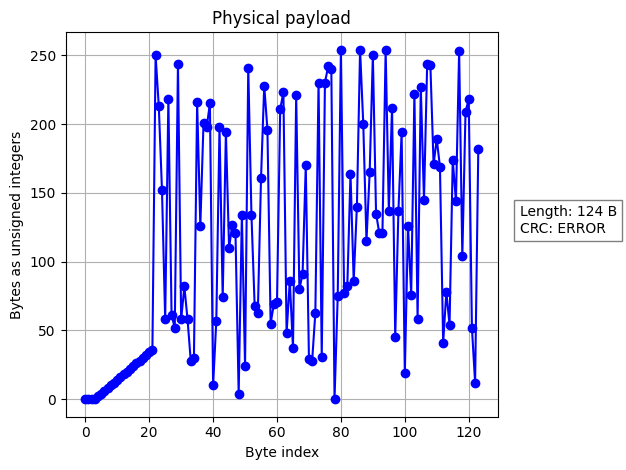

bit_error_rate = 36.59


In [3]:
# filename: str = "BLE_802154_0dBm_8dBm_0MHz.dat"
filename: str = "BLE_tone_0dBm_8dBm_0MHz.dat"

iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")  # Open file

# Initialise the receiver and process data
receiver = ReceiverBLE(fs=fs, decimation=decimation)
bit_samples = receiver.demodulate(iq_samples)  # From IQ samples to hard decisions
interfered_packet: list[dict] = receiver.process_phy_packet(bit_samples)  # From hard decisions to packets
interfered_packet: dict = interfered_packet[0]
plot_payload(interfered_packet)
plt.show()

bit2bit_difference = compare_bits_with_reference(interfered_packet["payload"], reference_packet["payload"])
bit_error_rate = sum(bit2bit_difference) / len(bit2bit_difference) * 100
print(f"{bit_error_rate = :.2f}")

# Read interference and plot it with interfered packet

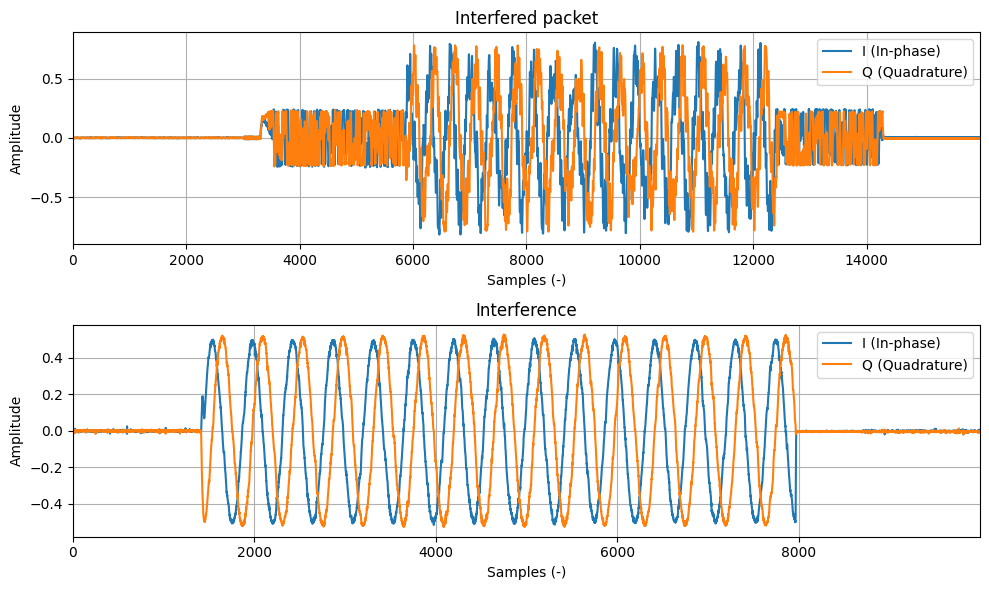

In [4]:
filename: str = "tone_8dBm_0MHz_BLE.dat"
# filename: str = "802154_8dBm_0MHz.dat"

# Open file
iq_samples_interference = read_iq_data(f"../capture_nRF/data/new/{filename}")
subplots_iq([iq_samples, iq_samples_interference], fs, ["Interfered packet", "Interference"])

## Correlate interference with interfered packet

max_idx = 3170
found_phase = -2.8804116


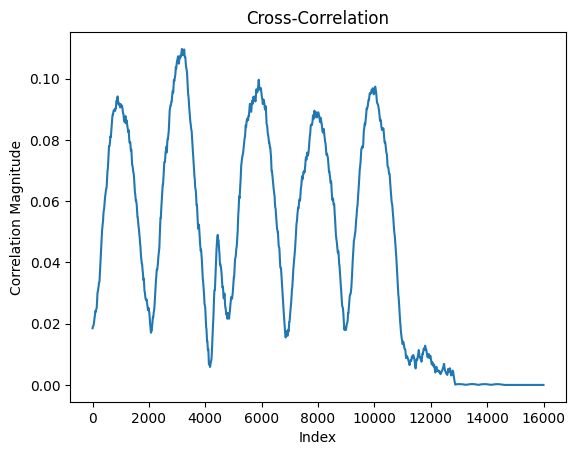

In [5]:
correlation = correlation_wrapper(iq_samples, iq_samples_interference)
max_idx = np.argmax(np.abs(correlation))
found_phase = np.angle(correlation[max_idx])
print(f"{max_idx = }")
print(f"{found_phase = }")

plt.plot(np.abs(correlation))
# plt.plot(np.imag(correlation))
plt.title("Cross-Correlation")
plt.xlabel("Index")
plt.ylabel("Correlation Magnitude")
plt.show()

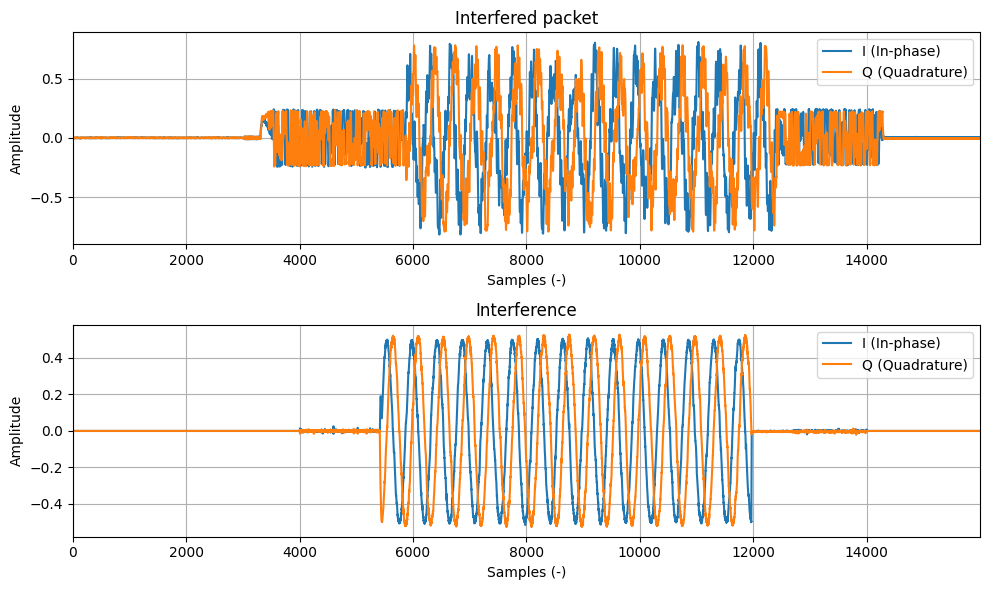

In [6]:
delayed_interference = pad_interference(iq_samples, iq_samples_interference, 4000)
subplots_iq([iq_samples, delayed_interference], fs, ["Interfered packet", "Interference"])

# Can the phase and amplitude be recovered with a complex correlation? (they can)

max_idx = 4000
found_phase = 0.5
estimated_amplitude = 1.0


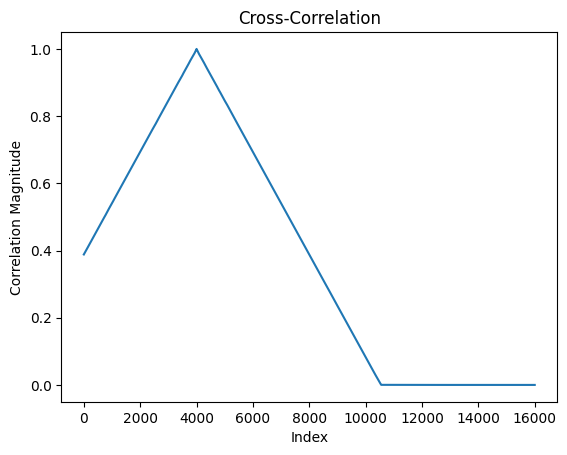

In [7]:
correlation = correlation_wrapper(delayed_interference * np.exp(1j * 0.5), iq_samples_interference)
max_idx = np.argmax(np.abs(correlation))
found_phase = np.angle(correlation[max_idx])
estimated_amplitude = np.abs(correlation[max_idx])
print(f"{max_idx = }")
print(f"{found_phase = }")
print(f"{estimated_amplitude = }")

plt.plot(np.abs(correlation))
# plt.plot(np.imag(correlation))
plt.title("Cross-Correlation")
plt.xlabel("Index")
plt.ylabel("Correlation Magnitude")
plt.show()

# Is there a carrier frequency variation that causes the correlation peak not to be when expected?

max_idx = 442
found_phase = -2.998356337942916
estimated_amplitude = 1.1117740312868392


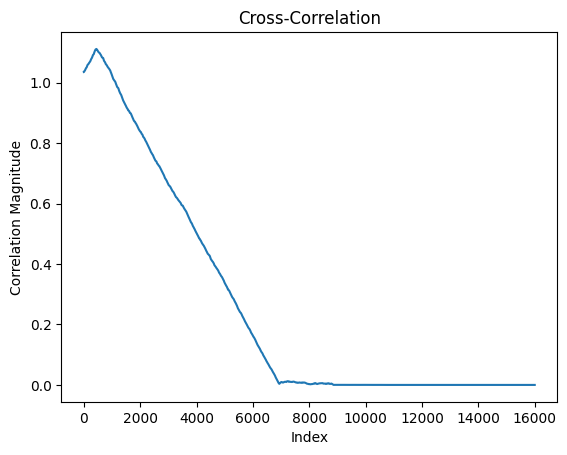

In [8]:
cos_interference = multiply_by_complex_exponential(delayed_interference, fs=fs, freq=4800)
correlation = correlation_wrapper(iq_samples, cos_interference)
max_idx = np.argmax(np.abs(correlation))
found_phase = np.angle(correlation[max_idx])
estimated_amplitude = np.abs(correlation[max_idx])

print(f"{max_idx = }")
print(f"{found_phase = }")
print(f"{estimated_amplitude = }")

plt.plot(np.abs(correlation))
# plt.plot(np.imag(correlation))
plt.title("Cross-Correlation")
plt.xlabel("Index")
plt.ylabel("Correlation Magnitude")
plt.show()

# Subtract!

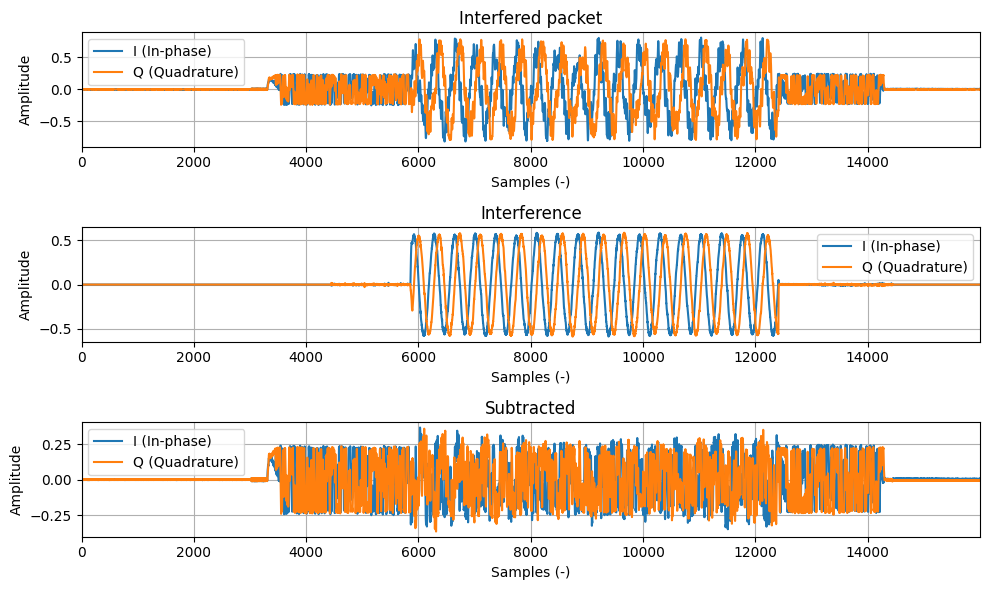

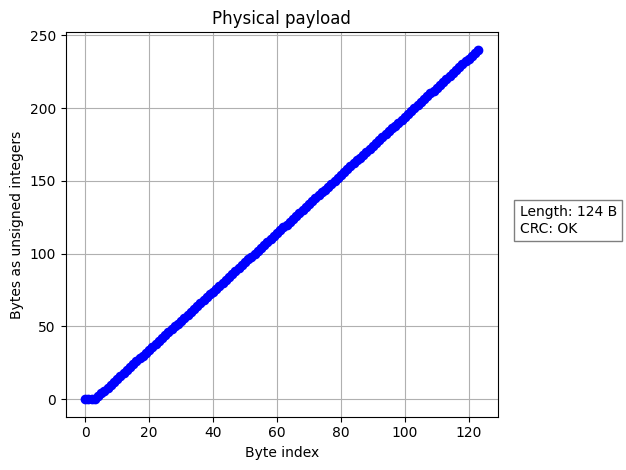

In [9]:
ready_to_subtract = multiply_by_complex_exponential(
    delayed_interference, fs, freq=4800, phase=found_phase, amplitude=estimated_amplitude
)
ready_to_subtract = pad_interference(iq_samples, ready_to_subtract, max_idx)
subtracted = iq_samples - ready_to_subtract
subplots_iq([iq_samples, ready_to_subtract, subtracted], fs, ["Interfered packet", "Interference", "Subtracted"])

# Initialise the receiver and process data
receiver = ReceiverBLE(fs=fs, decimation=decimation)
bit_samples = receiver.demodulate(subtracted)  # From IQ samples to hard decisions
reference_packet: list[dict] = receiver.process_phy_packet(bit_samples)  # From hard decisions to packets
if reference_packet:
    reference_packet: dict = reference_packet[0]
    plot_payload(reference_packet)
    plt.show()

# Encapsulate the process

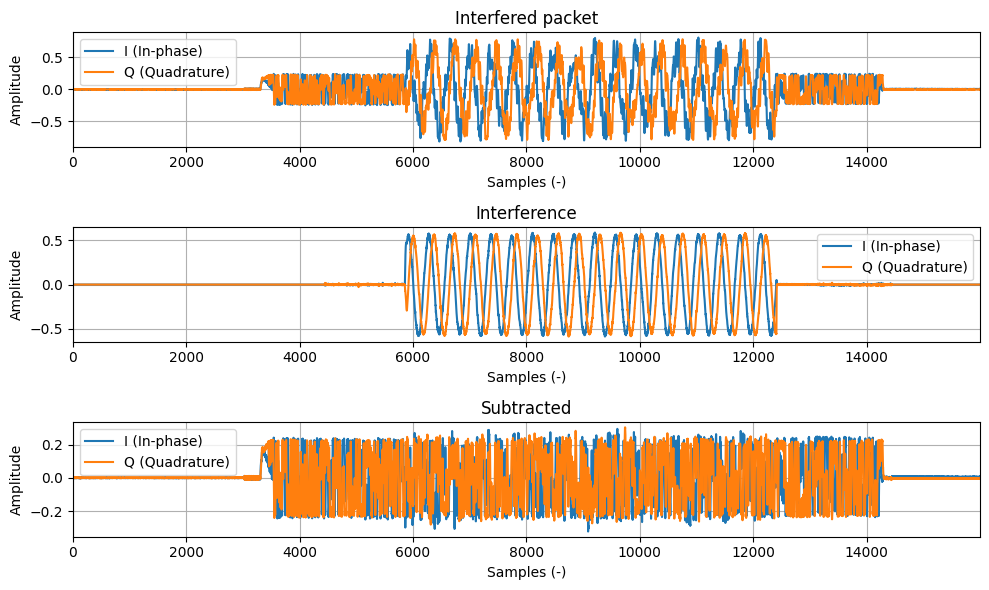

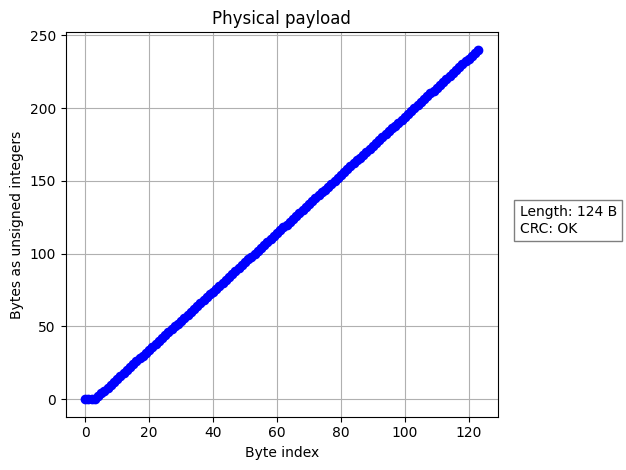

In [10]:
subtracted = subtract_interference_wrapper(
    affected=iq_samples, interference=iq_samples_interference, fs=fs, freq_offsets=range(4600, 5100, 100)
)
subplots_iq([iq_samples, ready_to_subtract, subtracted], fs, ["Interfered packet", "Interference", "Subtracted"])

# Initialise the receiver and process data
receiver = ReceiverBLE(fs=fs, decimation=decimation)
bit_samples = receiver.demodulate(subtracted)  # From IQ samples to hard decisions
reference_packet: list[dict] = receiver.process_phy_packet(bit_samples)  # From hard decisions to packets
if reference_packet:
    reference_packet: dict = reference_packet[0]
    plot_payload(reference_packet)
    plt.show()

# How do frequency deviations affect the demodulation? Comparison with known packet (BER)

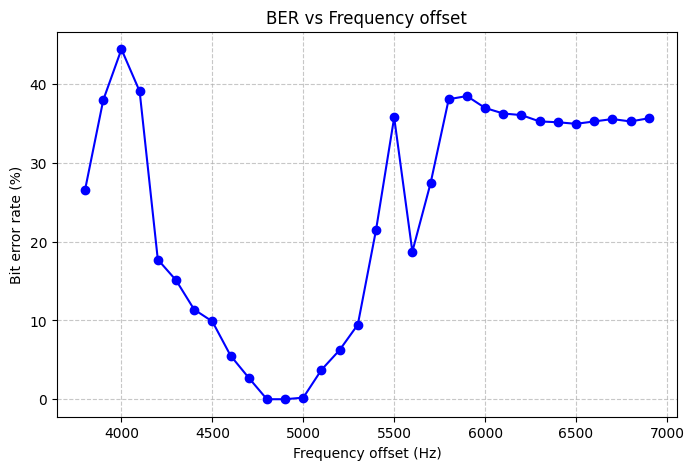

In [11]:
freq_range = range(3000, 7000, 100)
bit_error_rates = compute_ber_vs_frequency(
    freq_range,
    affected=iq_samples,
    interference=iq_samples_interference,
    fs=fs,
    reference_packet=reference_packet,
    receiver=receiver,
)
plot_ber_vs_frequency_offset(freq_range, bit_error_rates)